In [1]:
import sys
import re
sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

import glob
import numpy as np

from numpy import fft

import matplotlib.pyplot as plt

from frxas import time_domain, models, hdf5_io
%reload_ext autoreload
%autoreload 2

In [214]:
direc = r'D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV'


for i in range(1, 22):
    point = f'\\P{i}'
    all_files = glob.glob(direc + point+ '\\R[0-9] [0-9]*.txt')
    last_run = 0
    for files in all_files:
        run_ind = int(files.split('\\')[-1][1])
        if  run_ind > last_run:
            last_run = run_ind 
    amp = ''
    file = r'\R' + str(last_run)
    print(direc+point+amp+file)

    ti, V, J, Ir = time_domain.extract_data(direc, point, amp, file, end=301)

D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P1\R2
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P2\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P3\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P4\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P5\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P6\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P7\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P8\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P9\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P10\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P11\R2
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P12\R1
D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P13\R2


KeyboardInterrupt: 

In [192]:
%%time
direc = r'D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV'
freq = r'\0.25 Hz 150mV'
point = r'\P2'

# Find last run collected in case there were false starts
all_files = glob.glob(direc + point+ '\\R[0-9] [0-9]*.txt')
last_run = 0
for files in all_files:
    run_ind = int(files.split('\\')[-1][1])
    if  run_ind > last_run:
        last_run = run_ind 
amp = ''
file = r'\R' + str(last_run)
print(direc+point+amp+file)

ti, V, J, Ir = time_domain.extract_data(direc, point, amp, file, end=301)

match = re.search(r'\d+% O2', direc)
if match:
    gas = match.group()

Ns = ti.size
freq_in = time_domain.get_freq(direc, point, amp, file)
if Ns%2 == 1:
    Ns = Ns - 1
    ti = ti[:-1]
    V = V[:-1]
    J = J[:-1]
    Ir = Ir[:-1]

freq_bin_1 = time_domain.freq_bin(freq_in, fft.fftshift(fft.fftfreq(Ns, ti[1])), harmonic=1)
frequencies = fft.fftshift(fft.fftfreq(Ns, ti[1]))
weights = np.ones((Ns,))
for i in range(0, 10):
    weights[freq_bin_1+i] = 1
    weights[freq_bin_1-i] = 1

D:\UW Research\fr-XAS July 2018\Data\1% O2\0.25 Hz 150 mV\P2\R1
Wall time: 822 ms


In [211]:
%%time
b = 0.1 * f * (ti[-1]+ti[1])
harmonics = 1
fit_kws={'ftol':1e-13, 'xtol':1e-13}
J_adj, J_adj_fit = time_domain.phase_align(ti, V, J, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws)
Ir_adj, Ir_adj_fit = time_domain.phase_align(ti, V, Ir, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws, weights=weights)
V_adj, V_adj_fit = time_domain.phase_align(ti, V, V, freq_in, b, phase=0, harmonics=harmonics, fit_kws=fit_kws, weights=weights)

hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_J', J_adj_fit)
hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_Ir', Ir_adj_fit)
hdf5_io.save_time_domain_fit(f'July2018 Data Fits\\1% O2\\0.25 Hz 150 mV {str(point[1:])}_V', V_adj_fit)

Wall time: 7.33 s


In [194]:
Ir_adj_fit

c:\users\shadd\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


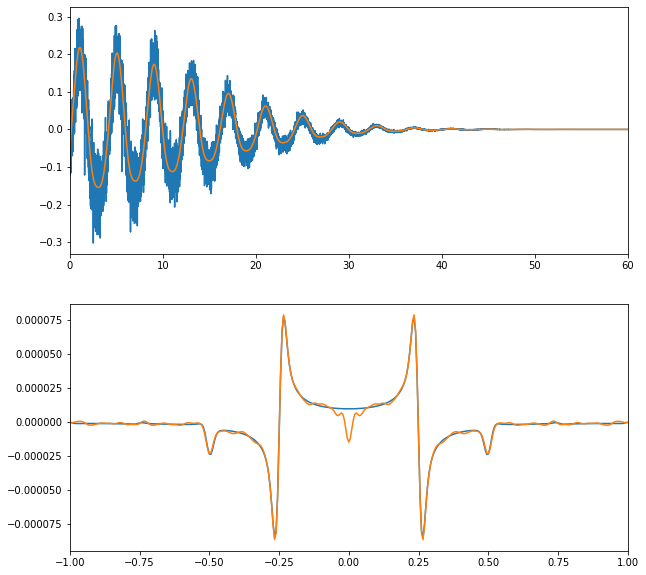

In [195]:
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
ax1.plot(ti, time_domain.gauss_window(Ir, freq_in, ti, b)*20)
ax1.plot(ti, Ir_adj*20)
# ax1.plot(ti, time_domain.gauss_window(V, freq_in, ti, b))
# ax1.plot(ti, V_adj)
ax1.set_xlim(0, 60)

ax2.plot(frequencies, Ir_adj_fit.eval().real)
ax2.plot(frequencies, time_domain.get_windowed_fft(ti, Ir, freq_in, b).real)
# ax2.plot(freq_list, V_adj_fit.eval().real)
# ax2.plot(freq_list, V_adj_fit.data.real)
ax2.set_xlim(-1, 1)

plt.show()

c:\users\shadd\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\shadd\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


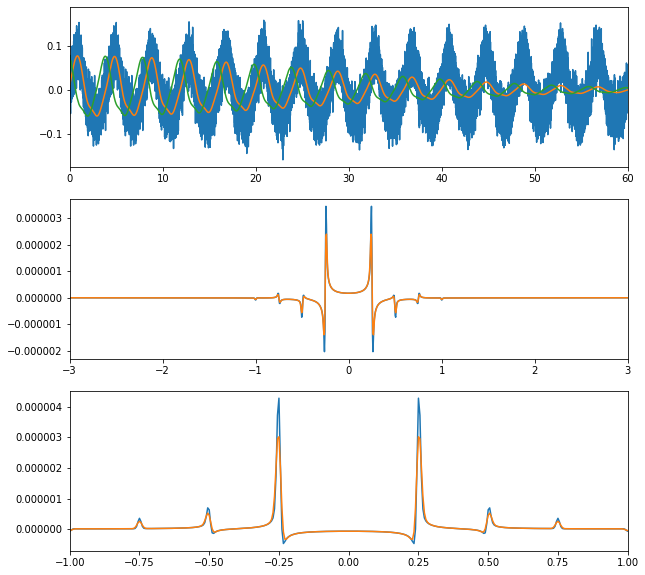

In [141]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,10))
ax1.plot(ti, J*400)
ax1.plot(ti, J_adj*400)
ax1.plot(ti, J_adj2*400)
ax1.set_xlim(0, 60)

freq_list = J_adj_fit2.userkws['frequencies']
ax2.plot(freq_list, J_adj_fit.eval().real)
ax2.plot(freq_list, J_adj_fit.data.real)
ax2.set_xlim(-3, 3)

ax3.plot(freq_list, J_adj_fit2.eval().real)
ax3.plot(freq_list, J_adj_fit2.data.real)
ax3.set_xlim(-1, 1)
# ax2.set_ylim(-1e-6,1e-6)
plt.show()

In [44]:
J_adj_fit.data - J_adj_fit2.data

array([2.97858081e-09+2.11052041e-09j, 6.84697198e-09+4.05240713e-09j,
       1.08302991e-08+2.09201658e-09j, ...,
       1.08302991e-08-2.09201658e-09j, 6.84697198e-09-4.05240713e-09j,
       2.97858081e-09-2.11052041e-09j])

In [46]:
time_domain.get_windowed_fft()

In [76]:
aa = 'str'
bb= 15
cc =1.5

isinstance(bb, str)

False